In [1]:
import bempp.api
import numpy as np

import sys
sys.path.append('../../')
from decimal import *

import bemppUQ
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field, evaluate_far_field_sd

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
bempp.api.global_parameters.hmat.eps = 1E-4


from bemppUQ.shapes import reentrant_cube_exterior

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)
    
    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)

    return zx * zy


# Def random:

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res



def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'B-P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)



def get_base_grid(h):

    gr0 = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1) 
    elements0 = list(gr0.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    tol = h / 10.
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2]) - z) < tol:
            gr0.mark(el0)
    gr1 = gr0.refine()


    elements0 = list(gr1.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2])-z) < tol:
            gr1.mark(el0)

    base_grid = gr1.refine()
    return base_grid


config = bemppUQ.config.set_case('A')

axis = 0
#### define l0 and l1

l0 = 0
l1 = 2

precision_list = [2, 4, 8]

precision0 = precision_list[l0]
precision1 = precision_list[l1]

h0 = 2.0 * np.pi / (precision0 * config["k_int"])
h1 = 2.0 * np.pi / (precision1 * config["k_int"])

# generate the grids

if l0 == 2:
    grid0 = get_base_grid(h=h0) 
else:
    grid0 = bempp.api.shapes.reentrant_cube(h=h0, refinement_factor=1) 

if l1 == 2:
    grid1 = get_base_grid(h=h1)
else:
    grid1 = bempp.api.shapes.reentrant_cube(h=h1, refinement_factor=1) 
    
N0 = 2 * grid0.leaf_view.entity_count(1)
N1 = 2 * grid1.leaf_view.entity_count(1)

print(N0, N1, N0 * N1)

solve = False

270 2136 576720


In [2]:
transmission_operators0 = assemble_operators(grid0, config)
transmission_operators1 = assemble_operators(grid1, config)


Umean0, solution0 = evaluate_far_field(transmission_operators0, config)
Umean1, solution1 = evaluate_far_field(transmission_operators1, config)

nrank = 1
grid_funs0 = []
grid_funs1 = []

for ii in range(nrank):
    for jj in range(nrank):
        print(ii,jj)
        def fun(point, n, domain_index, result):
            x, y, z = point

            res = 0j
            if z == 0.5 and (x <= 0.5) and (y <= 0.5):
                res += function(x, y, ii,jj)
            result[0] = res
            
        space0 = bempp.api.function_space(grid0, 'B-P', 1)
        grid_fun0 = bempp.api.GridFunction(space0, fun= fun)
        grid_funs0.append(grid_fun0)
        
        space1 = bempp.api.function_space(grid1, 'B-P', 1)
        grid_fun1 = bempp.api.GridFunction(space1, fun= fun)
        grid_funs1.append(grid_fun1)

iteration - 1 || residual - 0.168293504673 0.1246345043182373
iteration - 2 || residual - 0.0342926663974 0.08936929702758789
iteration - 3 || residual - 0.00697678782673 0.07824993133544922
iteration - 4 || residual - 0.00134549558822 0.12229466438293457
iteration - 5 || residual - 0.000286475256428 0.10393548011779785
iteration - 6 || residual - 5.47553417365e-05 0.09220576286315918
iteration - 7 || residual - 7.79029742939e-06 0.03417158126831055
iteration - 1 || residual - 0.160652466858 0.6337852478027344
iteration - 2 || residual - 0.0347347614732 0.3520047664642334
iteration - 3 || residual - 0.00765102059475 0.3634798526763916
iteration - 4 || residual - 0.00124260806634 0.34435439109802246
iteration - 5 || residual - 0.000254417938232 0.39005064964294434
iteration - 6 || residual - 5.41917001396e-05 0.33755016326904297
iteration - 7 || residual - 1.23021210075e-05 0.3482213020324707
iteration - 8 || residual - 2.22356186698e-06 0.014137029647827148
0 0


In [3]:
result0 = evaluate_far_field_sd(grid0, transmission_operators0, config, solution0, grid_funs0, solve = solve)
result1 = evaluate_far_field_sd(grid1, transmission_operators1, config, solution1, grid_funs1, solve = solve)

0
0


In [4]:
result0, lhs_op0 = result0
result1, lhs_op1 = result1

In [5]:
from bemppUQ.assembly.operators import HDenseTensorLinearOperator
from bempp.api.assembly.blocked_operator import \
        coefficients_of_grid_function_list, \
        projections_of_grid_function_list, \
        grid_function_list_from_coefficients

In [6]:
lhs_op0

In [7]:
#AA = DenseTensorLinearOperator(A, A)
#ff = np.dot(np.array([f]).T, np.array([f])).ravel()
#print('solver Osrc')
#x, info, res, timing = gmres( AA ,ff, return_residuals=True,restart=restart, maxiter=maxiter, tol=tolerance)

In [8]:
N0 = 2 * grid0.leaf_view.entity_count(1)
N1 = 2 * grid1.leaf_view.entity_count(1)

print(N0)
print(N1)

270
2136


In [9]:
n = config['number_of_angles']

C = np.zeros((N0, N1), dtype=np.complex128)
Sigma = np.zeros((n, n), dtype=np.complex128)
k = 0
for ii in range(nrank):
    for jj in range(nrank):
        cc0 = coefficients_of_grid_function_list(result0[k])
        cc1 = coefficients_of_grid_function_list(result1[k])
        C += 1/3. * bemppUQ.utils.login.tensorize(cc0,cc1)
        k += 1
        
t = 0.05

A0 = (lhs_op0 * lhs_op0).strong_form()
A1 = (lhs_op1 * lhs_op1).strong_form()

AA = HDenseTensorLinearOperator(A0, A1)

#Uvars = t ** 2 * Sigma.diagonal()
#Umeans = Umean1[axis]

In [10]:
print('C', C.shape)
print('lhs_op0', lhs_op0.weak_form().shape)
print('lhs_op1', lhs_op1.weak_form().shape)

C (270, 2136)
lhs_op0 (270, 270)
lhs_op1 (2136, 2136)


In [11]:
from bemppUQ.utils.login import gmres

print('0')
test = A0 * C
print('1')
test2 = (A1 * test.conj().T).conj().T

0
1


In [12]:
X, info, res, times = gmres(AA, np.ravel(test2), return_residuals=True)

iteration - 1 || residual - 0.176646672212 287.443350315094
iteration - 2 || residual - 0.0499807781612 153.59467029571533
iteration - 3 || residual - 0.0123484089304 142.96732544898987
iteration - 4 || residual - 0.00342246842883 155.27200937271118
iteration - 5 || residual - 0.00106056612919 141.68020462989807
iteration - 6 || residual - 0.000329079610703 130.1466841697693
iteration - 7 || residual - 0.000110499084612 124.8201048374176
iteration - 8 || residual - 3.92689822872e-05 147.46729588508606
iteration - 9 || residual - 1.43843396824e-05 159.93000173568726
iteration - 10 || residual - 5.279295336e-06 0.11151409149169922


In [14]:
len(transmission_operators0)

5

In [15]:
electric_far0, magnetic_far0 = transmission_operators0[3], transmission_operators0[4] 
electric_far1, magnetic_far1 = transmission_operators1[3], transmission_operators1[4] 

In [33]:
E0 = bempp.api.as_matrix(electric_far0.discrete_operator)
M0 = bempp.api.as_matrix(magnetic_far0.discrete_operator)
Z0 = np.zeros(E0.shape, dtype = E0.dtype)

E1 = bempp.api.as_matrix(electric_far1.discrete_operator)
M1 = bempp.api.as_matrix(magnetic_far1.discrete_operator)
Z1 = np.zeros(E1.shape, dtype = E1.dtype)

R0 = np.bmat([Z0, -E0], [-M0, Z0])
R1 = np.bmat([Z1, -E1], [-M1, Z1])

In [75]:
R0.shape

(1200, 270)

In [37]:
X = X.reshape(C.shape)

In [40]:
X.shape

(270, 2136)

In [42]:
R0.shape

(1200, 270)

In [68]:
FF.shape

(1200, 1200)

In [63]:
Xtemp = np.dot(R0, X)
FF = np.dot(Xtemp, R1.T)

In [80]:
Uvar = t ** 2 * FF.diagonal()

array([ -1.44497615e-05 +3.57405577e-06j,
        -1.91502557e-07 -1.39829825e-06j,
        -6.13022429e-06 -1.01892350e-05j,
        -1.43585972e-05 +3.67566242e-06j,
        -3.91883796e-07 -1.32281538e-06j,
        -6.31454668e-06 -1.02641081e-05j,
        -1.42549909e-05 +3.78121842e-06j,
        -6.02002925e-07 -1.27464972e-06j,
        -6.50683614e-06 -1.03170874e-05j,
        -1.41386255e-05 +3.89026886e-06j,
        -8.19916948e-07 -1.25418319e-06j,
        -6.70625023e-06 -1.03486582e-05j,
        -1.40091926e-05 +4.00231773e-06j,
        -1.04368170e-06 -1.26149147e-06j,
        -6.91193553e-06 -1.03593962e-05j,
        -1.38663940e-05 +4.11683109e-06j,
        -1.27128645e-06 -1.29633963e-06j,
        -7.12304969e-06 -1.03499560e-05j,
        -1.37099445e-05 +4.23323246e-06j,
        -1.50078510e-06 -1.35818361e-06j,
        -7.33875394e-06 -1.03210693e-05j,
        -1.35395695e-05 +4.35090918e-06j,
        -1.73028314e-06 -1.44616889e-06j,
        -7.55821698e-06 -1.0273512

In [102]:
Uvars = np.array(np.sum(Uvar.reshape(3,400), axis=0)).ravel()
Umeans = np.sum(Umean0, axis=0)

In [103]:
#sol_p = grid_function_list_from_coefficients(x, lhs_op.domain_spaces)
#far_field_p = (-electric_far * sol_p[1] - magnetic_far * sol_p[0])

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


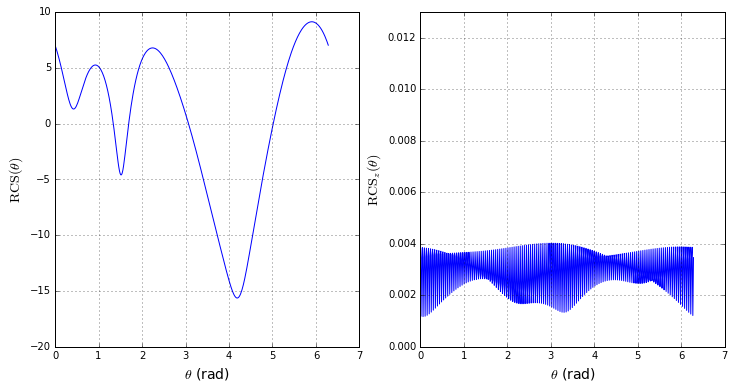

In [104]:
from matplotlib import pyplot as plt

angles = config['angles']

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,6))

cs = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)

ax1.plot(angles, cs)


    y = np.sqrt(np.abs(Uvars))
ax2.plot(angles, y)


ax2.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax2.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)


ax1.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\mathrm{RCS}(\theta)$', fontsize=14)

ax1.legend()
ax1.grid()

ax2.legend()
ax2.grid()
ax2.set_ylim(0, 0.013)

plt.show(block=False)


In [106]:
Uvars

array([ -1.44497615e-05 +3.57405577e-06j,
        -1.91502557e-07 -1.39829825e-06j,
        -6.13022429e-06 -1.01892350e-05j,
        -1.43585972e-05 +3.67566242e-06j,
        -3.91883796e-07 -1.32281538e-06j,
        -6.31454668e-06 -1.02641081e-05j,
        -1.42549909e-05 +3.78121842e-06j,
        -6.02002925e-07 -1.27464972e-06j,
        -6.50683614e-06 -1.03170874e-05j,
        -1.41386255e-05 +3.89026886e-06j,
        -8.19916948e-07 -1.25418319e-06j,
        -6.70625023e-06 -1.03486582e-05j,
        -1.40091926e-05 +4.00231773e-06j,
        -1.04368170e-06 -1.26149147e-06j,
        -6.91193553e-06 -1.03593962e-05j,
        -1.38663940e-05 +4.11683109e-06j,
        -1.27128645e-06 -1.29633963e-06j,
        -7.12304969e-06 -1.03499560e-05j,
        -1.37099445e-05 +4.23323246e-06j,
        -1.50078510e-06 -1.35818361e-06j,
        -7.33875394e-06 -1.03210693e-05j,
        -1.35395695e-05 +4.35090918e-06j,
        -1.73028314e-06 -1.44616889e-06j,
        -7.55821698e-06 -1.0273512